In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
import torch
import torchvision
import numpy as np
import pandas as pd
import PIL
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [4]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
augmented_images_paths = Path("/content/drive/MyDrive/Medical_Dataset")
augmented_train_dir = Path("/content/drive/MyDrive/Medical_Dataset/train_augmented") #using Path funtion to get paths from drive in PosixPath format
test_dir = Path("/content/drive/MyDrive/Medical_Dataset/test")

augmented_images_paths, augmented_train_dir, test_dir

(PosixPath('/content/drive/MyDrive/Medical_Dataset'),
 PosixPath('/content/drive/MyDrive/Medical_Dataset/train_augmented'),
 PosixPath('/content/drive/MyDrive/Medical_Dataset/test'))

In [6]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"could not load the helper_functions.py file, downloading")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/helper_functions.py")
    f.write(request.content)

could not load the helper_functions.py file, downloading


Resizing and Converting the images to Tensors

In [7]:
from torchvision import datasets, transforms
import random
from PIL import Image

image_path_list = list(augmented_images_paths.glob("*/*/*.jpg"))

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [9]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.Lambda(lambda img: img.convert('RGB')), # 4 channels to 3 channels
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    normalize #done to make sure, this dataset has the same image distribution as ImageNet
])

path of the image is: /content/drive/MyDrive/Medical_Dataset/train/Ringworms (Skin Fungal Infection)/img (106).jpg
class of the image is: Ringworms (Skin Fungal Infection)


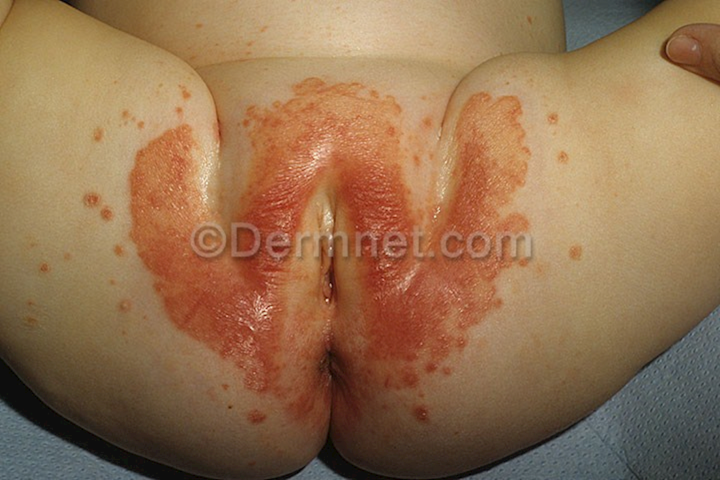

In [10]:
#picking a random image from the list and then printing it out
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"path of the image is: {random_image_path}")
print(f"class of the image is: {image_class}")
img

In [11]:
print(f"image tensor: {data_transform(img)}")
print(f"image shape/size: {data_transform(img).shape}")

image tensor: tensor([[[ 0.3994,  0.4166,  0.3652,  ...,  0.3309,  0.4166,  0.5022],
         [ 0.4166,  0.3994,  0.3823,  ...,  0.3481,  0.4508,  0.5022],
         [ 0.4508,  0.4337,  0.3994,  ...,  0.3823,  0.4851,  0.5193],
         ...,
         [-1.2274, -1.3302, -1.2617,  ..., -0.6281, -0.6281, -0.5253],
         [-1.1418, -1.3130, -1.2788,  ..., -0.5938, -0.6109, -0.6452],
         [-1.3130, -1.3473, -1.2959,  ..., -0.6281, -0.5938, -0.5938]],

        [[ 0.0826,  0.1001,  0.0651,  ...,  0.0301,  0.1001,  0.1527],
         [ 0.1001,  0.0826,  0.0651,  ..., -0.0049,  0.1176,  0.1527],
         [ 0.1352,  0.1001,  0.0826,  ..., -0.0049,  0.1352,  0.1702],
         ...,
         [-1.0203, -1.1078, -1.0378,  ..., -0.2325, -0.2500, -0.1450],
         [-0.9328, -1.1078, -1.0728,  ..., -0.1975, -0.2325, -0.2675],
         [-1.0903, -1.1429, -1.0903,  ..., -0.2500, -0.2150, -0.2150]],

        [[-0.5844, -0.5495, -0.6018,  ..., -0.7238, -0.5844, -0.4450],
         [-0.5670, -0.5670, -0.

Creating Updated datasets with augmented image folder

In [12]:
train_data = datasets.ImageFolder(root=augmented_train_dir,
                      transform=data_transform,
                      target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                     transform=data_transform)

In [13]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 12000
     Root location: /content/drive/MyDrive/Medical_Dataset/train_augmented
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                Lambda()
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 787
     Root location: /content/drive/MyDrive/Medical_Dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                Lambda()
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ))

FROM HERE NOW IT IS CLEAR THAT THE DATASET IS NOW HAVING 12000 AUGMENTED IMAGES IN TOTAL, 1500 IMAGES FOR 8 CLASSES EACH

In [14]:
class_names = train_data.classes
classes_to_idx = train_data.class_to_idx

In [15]:
class_names, classes_to_idx

(['Acne (Normal to Mild)',
  'Conjunctivitis',
  'Folliculitis',
  'Hives Urticaria',
  'Nail Fungus and Cracked Nails',
  'Ringworms (Skin Fungal Infection)',
  'Stye (Inflammation around eyes)',
  'Warts'],
 {'Acne (Normal to Mild)': 0,
  'Conjunctivitis': 1,
  'Folliculitis': 2,
  'Hives Urticaria': 3,
  'Nail Fungus and Cracked Nails': 4,
  'Ringworms (Skin Fungal Infection)': 5,
  'Stye (Inflammation around eyes)': 6,
  'Warts': 7})

Preparing the train and test DataLoader

In [16]:
from torch.utils.data import DataLoader

In [17]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              num_workers=1,
                              shuffle=False)

In [18]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bf57016dd50>,
 <torch.utils.data.dataloader.DataLoader at 0x7bf57783fe10>)

In [19]:
len(train_dataloader), len(test_dataloader), len(train_data), len(test_data)

(375, 25, 12000, 787)

In [20]:
img, label = next(iter(train_dataloader))
print(f"image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"label shape: {label.shape}")

image shape: torch.Size([32, 3, 256, 256]) -> [batch_size, color_channels, height, width]
label shape: torch.Size([32])


In [21]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 4393 (delta 1456), reused 1401 (delta 1401), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 28.27 MiB/s, done.
Resolving deltas: 100% (2659/2659), done.
Updating files: 100% (248/248), done.


From the imported files, again creating separate dataloaders

In [22]:
from going_modular.going_modular import data_setup

#manually creating the transform

from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([transforms.Resize((256,256)),
                                        transforms.ToTensor(), #to get the images in the range 0 to 1
                                        normalize]) #to make sure each image have the same distribution as ImageNet

train_dataloader_2, test_dataloader_2, class_names_2 = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transform,
                                                                               batch_size=32)

EfficientNet_B0_Weights

In [23]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT #getting the pre-trained weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [24]:
#Getting the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [25]:
#Create Dataloaders using auto_transforms
train_dataloader_2, test_dataloader_2, class_names_2 = data_setup.create_dataloaders(train_dir=augmented_train_dir,
                                                                                      test_dir=test_dir,
                                                                                      transform=auto_transforms,
                                                                                      batch_size=32)
train_dataloader_2, test_dataloader_2, class_names_2

(<torch.utils.data.dataloader.DataLoader at 0x7bf55d292250>,
 ['Acne (Normal to Mild)',
  'Conjunctivitis',
  'Folliculitis',
  'Hives Urticaria',
  'Nail Fungus and Cracked Nails',
  'Ringworms (Skin Fungal Infection)',
  'Stye (Inflammation around eyes)',
  'Warts'])

It is important to note that the data which is to be passed through the pre-trained model is to be transformed wrt auto-auto_transforms. It is a must for maximum accuracy

Creating the pre-trained model now

In [26]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model_v1 = torchvision.models.efficientnet_b0(weights=weights)
model_v1

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 111MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [27]:
model_v1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

Checking out the model's Summary

In [28]:
from torchinfo import summary

summary(model=model_v1,
        input_size=(1,3,256,256),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 256, 256]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 256, 256]     [1, 1280, 8, 8]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 256, 256]     [1, 32, 128, 128]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 256, 256]     [1, 32, 128, 128]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 128, 128]    [1, 32, 128, 128]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 128, 128]    [1, 32, 128, 128]    --                   --
│    └─Sequential (1)                                        [1, 32, 128, 128]    [1, 16, 128,

Freeze all the base layer to change the output shape to match the length of class

In [29]:
for param in model_v1.features.parameters():
  param.requires_grad = False

In [30]:
from torchinfo import summary

summary(model=model_v1,
        input_size=(1,3,256,256),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 256, 256]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 256, 256]     [1, 1280, 8, 8]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 256, 256]     [1, 32, 128, 128]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 256, 256]     [1, 32, 128, 128]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 128, 128]    [1, 32, 128, 128]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 128, 128]    [1, 32, 128, 128]    --                   --
│    └─Sequential (1)                                        [1, 32, 128, 128]    [1, 1

####Setting up the correct number of Output Features

In [31]:
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_v1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True), #dropout technique is proved to be effective in regularization and preventing overfitting. Here, randomly nodes are removed/turned off, which are p=0.2, i.e 20% will be dropped
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names)).to(device) # instead of 1000 classes, we have only 8 classes
)
model_v1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=8, bias=True)
)

###Training the model_v1

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v1.parameters(), lr=0.001)

Training for 15 Epochs (INITIAL)

In [33]:
#Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_5 = engine.train(model=model_v1,
                          train_dataloader=train_dataloader_2,
                          test_dataloader=test_dataloader_2,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=15,
                          device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8634 | train_acc: 0.7302 | test_loss: 0.5082 | test_acc: 0.8232
Epoch: 2 | train_loss: 0.5595 | train_acc: 0.8150 | test_loss: 0.4012 | test_acc: 0.8757
Epoch: 3 | train_loss: 0.4901 | train_acc: 0.8370 | test_loss: 0.3754 | test_acc: 0.8599
Epoch: 4 | train_loss: 0.4494 | train_acc: 0.8478 | test_loss: 0.3059 | test_acc: 0.8953
Epoch: 5 | train_loss: 0.4402 | train_acc: 0.8478 | test_loss: 0.2999 | test_acc: 0.8869
Epoch: 6 | train_loss: 0.4211 | train_acc: 0.8571 | test_loss: 0.3058 | test_acc: 0.8865
Epoch: 7 | train_loss: 0.4170 | train_acc: 0.8535 | test_loss: 0.2751 | test_acc: 0.8995
Epoch: 8 | train_loss: 0.3997 | train_acc: 0.8624 | test_loss: 0.2813 | test_acc: 0.9049
Epoch: 9 | train_loss: 0.3941 | train_acc: 0.8632 | test_loss: 0.2562 | test_acc: 0.9099
Epoch: 10 | train_loss: 0.3871 | train_acc: 0.8645 | test_loss: 0.2673 | test_acc: 0.9090
Epoch: 11 | train_loss: 0.3848 | train_acc: 0.8658 | test_loss: 0.2735 | test_acc: 0.9011
Epoch: 12 | train_l

In [35]:
# Save the model's state_dict (weights)
torch.save(model_v1.state_dict(), 'Med_Vision_model_v1_effnet_weights_(or_state_dicts)_15E.pth')

In [36]:
# Save the entire model (architecture + weights)
torch.save(model_v1, 'Med_Vision_model_v1_effnet_full_architecture_and_weights_15E.pth')

In [37]:
# Save only the optimizer state dict
torch.save(optimizer.state_dict(), 'Med_Vision_model_v1_optimizer_state_15E.pth')

In [38]:
# Save both model weights and optimizer state_dict
torch.save({
    # 'epoch': Epoch,  # Current epoch
    'model_state_dict': model_v1.state_dict(),  # Model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
    'loss_fn': loss_fn,  # Last loss
}, 'Med_Vision_model_with_weights_and_optimizer_15E.pth')

In [34]:
# Save a checkpoint during training
checkpoint = {
    # 'epoch': Epoch,
    'model_state_dict': model_v1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_fn': loss_fn
}

torch.save(checkpoint, 'checkpoint_after_15_Epochs.pth')

####Training for additional 5 Epochs (Total 20 Epochs)

In [39]:
#Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

results_10 = engine.train(model=model_v1,
                          train_dataloader=train_dataloader_2,
                          test_dataloader=test_dataloader_2,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=5,
                          device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3632 | train_acc: 0.8680 | test_loss: 0.2315 | test_acc: 0.9136
Epoch: 2 | train_loss: 0.3576 | train_acc: 0.8742 | test_loss: 0.2380 | test_acc: 0.9153
Epoch: 3 | train_loss: 0.3540 | train_acc: 0.8725 | test_loss: 0.2343 | test_acc: 0.9136
Epoch: 4 | train_loss: 0.3413 | train_acc: 0.8787 | test_loss: 0.2065 | test_acc: 0.9320
Epoch: 5 | train_loss: 0.3589 | train_acc: 0.8700 | test_loss: 0.2229 | test_acc: 0.9174


In [40]:
# Save the model's state_dict (weights)
torch.save(model_v1.state_dict(), 'Med_Vision_model_v1_effnet_weights_(or_state_dicts)_20E.pth')

In [41]:
# Save the entire model (architecture + weights)
torch.save(model_v1, 'Med_Vision_model_v1_effnet_full_architecture_and_weights_20E.pth')

In [42]:
# Save only the optimizer state dict
torch.save(optimizer.state_dict(), 'Med_Vision_model_v1_optimizer_state_20E.pth')

In [43]:
# Save both model weights and optimizer state_dict
torch.save({
    # 'epoch': epoch,  # Current epoch
    'model_state_dict': model_v1.state_dict(),  # Model weights
    'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
    'loss_fn': loss_fn,  # Last loss
}, 'Med_Vision_model_with_weights_and_optimizer_20E.pth')

In [44]:
# Save a checkpoint during training
checkpoint = {
    # 'epoch': epoch,
    'model_state_dict': model_v1.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_fn': loss_fn
}

torch.save(checkpoint, 'checkpoint_after_20_Epochs.pth')

####Training for additional 5 Epochs (Total 25 Epochs)

In [ ]:
# #Import train function
# from going_modular.going_modular import engine

# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# results_10 = engine.train(model=model_v1,
#                           train_dataloader=train_dataloader_2,
#                           test_dataloader=test_dataloader_2,
#                           optimizer=optimizer,
#                           loss_fn=loss_fn,
#                           epochs=5,
#                           device=device)

In [ ]:
# # Save the model's state_dict (weights)
# torch.save(model_v1.state_dict(), 'Med_Vision_model_v1_effnet_weights_(or_state_dicts)_25E.pth')

In [ ]:
# # Save the entire model (architecture + weights)
# torch.save(model_v1, 'Med_Vision_model_v1_effnet_full_architecture_and_weights_20E.pth')

In [ ]:
# # Save only the optimizer state dict
# torch.save(optimizer.state_dict(), 'Med_Vision_model_v1_optimizer_state_20E.pth')

In [ ]:
# # Save both model weights and optimizer state_dict
# torch.save({
#     # 'epoch': epoch,  # Current epoch
#     'model_state_dict': model_v1.state_dict(),  # Model weights
#     'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
#     'loss_fn': loss_fn,  # Last loss
# }, 'Med_Vision_model_with_weights_and_optimizer_20E.pth')

In [ ]:
# # Save a checkpoint during training
# checkpoint = {
#     # 'epoch': epoch,
#     'model_state_dict': model_v1.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss_fn': loss_fn
# }

# torch.save(checkpoint, 'checkpoint_after_20_Epochs.pth')

###Predictions Using the Model

Defining a function to take a model, image path, class names, image size to be used, transform, and device (to put it to GPU)

In [60]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

def Show_Predcitions(model: torch.nn.Module,
                     uploaded_image_path: str,
                     class_names: List[str],
                     image_size: Tuple[int, int] = (256,256),
                     transform: torchvision.transforms = None):
  img = Image.open(uploaded_image_path)

  #transforming the image as per the requirements
  if transform is not None:
    image_transform = transforms
  else:
    image_transforms = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    model.eval()
    with torch.inference_mode():
      transformed_image = image_transforms(img).unsqueeze(axis=0) #adding ectra batch dimension

      #making a prediction
      target_image_pred = model(transformed_image) #this will output raw logits

    #Using softmax to convert them into prediction probabilities
    target_image_pred_prob = torch.softmax(target_image_pred, dim=1)

    #Using argmax to find the class/label from the predicted probability
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names_2[target_image_pred_label]} | "
        f"Probability: {target_image_pred_prob.max():.3f}"
        if target_image_pred_prob.max() > 0.5
        else f"Pred: {class_names_2[target_image_pred_label]} | Probability: sorry"
    )
    plt.axis(False)

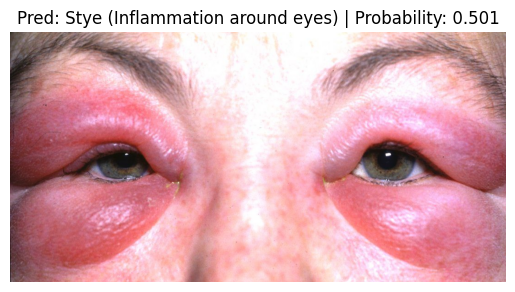

In [61]:
path = "/content/sample_data/image013-1-e1574446074562.jpg"
Show_Predcitions(model=model_v1.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )

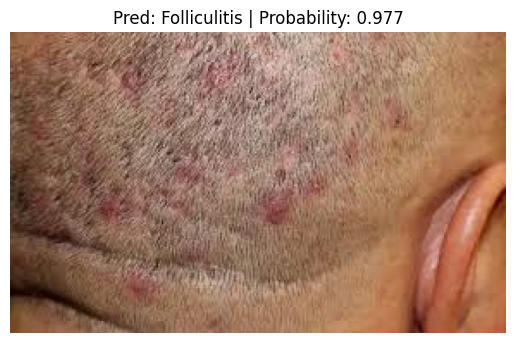

In [63]:
path = "/content/sample_data/images(2).jpg"
Show_Predcitions(model=model_v1.cpu(),
                 uploaded_image_path=path,
                 class_names=class_names,
                 image_size=(256,256),
                 )